In [302]:
import pandas as pd
import numpy as np
import collections
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [152]:
public_df = pd.read_csv("survey_results_public.csv", low_memory=False)
public_df.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


In [153]:
public_df.shape

(98855, 129)

In [154]:
public_df.columns.tolist()

['Respondent',
 'Hobby',
 'OpenSource',
 'Country',
 'Student',
 'Employment',
 'FormalEducation',
 'UndergradMajor',
 'CompanySize',
 'DevType',
 'YearsCoding',
 'YearsCodingProf',
 'JobSatisfaction',
 'CareerSatisfaction',
 'HopeFiveYears',
 'JobSearchStatus',
 'LastNewJob',
 'AssessJob1',
 'AssessJob2',
 'AssessJob3',
 'AssessJob4',
 'AssessJob5',
 'AssessJob6',
 'AssessJob7',
 'AssessJob8',
 'AssessJob9',
 'AssessJob10',
 'AssessBenefits1',
 'AssessBenefits2',
 'AssessBenefits3',
 'AssessBenefits4',
 'AssessBenefits5',
 'AssessBenefits6',
 'AssessBenefits7',
 'AssessBenefits8',
 'AssessBenefits9',
 'AssessBenefits10',
 'AssessBenefits11',
 'JobContactPriorities1',
 'JobContactPriorities2',
 'JobContactPriorities3',
 'JobContactPriorities4',
 'JobContactPriorities5',
 'JobEmailPriorities1',
 'JobEmailPriorities2',
 'JobEmailPriorities3',
 'JobEmailPriorities4',
 'JobEmailPriorities5',
 'JobEmailPriorities6',
 'JobEmailPriorities7',
 'UpdateCV',
 'Currency',
 'Salary',
 'SalaryType',

In [155]:
data_df = public_df[['Employment','LanguageWorkedWith','YearsCodingProf','DevType','CompanySize','OpenSource','Country','FormalEducation','ConvertedSalary']]
data_df.head()

,Employment,LanguageWorkedWith,YearsCodingProf,DevType,CompanySize,OpenSource,Country,FormalEducation,ConvertedSalary
0,Employed part-time,JavaScript;Python;HTML;CSS,3-5 years,Full-stack developer,20 to 99 employees,No,Kenya,"Bachelor’s degree (BA, BS, B.Eng., etc.)",NaN
1,Employed full-time,JavaScript;Python;Bash/Shell,18-20 years,Database administrator;DevOps specialist;Full-...,"10,000 or more employees",Yes,United Kingdom,"Bachelor’s degree (BA, BS, B.Eng., etc.)",70841.0
2,Employed full-time,NaN,6-8 years,Engineering manager;Full-stack developer,20 to 99 employees,Yes,United States,Associate degree,NaN
3,Employed full-time,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,12-14 years,Full-stack developer,100 to 499 employees,No,United States,"Bachelor’s degree (BA, BS, B.Eng., etc.)",NaN
4,Employed full-time,C;C++;Java;Matlab;R;SQL;Bash/Shell,0-2 years,Data or business analyst;Desktop or enterprise...,"10,000 or more employees",No,South Africa,Some college/university study without earning ...,21426.0


In [156]:
data_df['ConvertedSalary'] = data_df['ConvertedSalary'].fillna(0)
data_df = data_df[data_df['ConvertedSalary'] > 0]

/Users/zhehaoguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [157]:
data_df['Employment'].value_counts()

Employed full-time                                      39266
Independent contractor, freelancer, or self-employed     3935
Employed part-time                                       2237
Not employed, but looking for work                        918
Not employed, and not looking for work                    347
Retired                                                    27
Name: Employment, dtype: int64

In [158]:
data_df = data_df[(data_df['Employment'] == 'Employed full-time') | (data_df['Employment'] == 'Independent contractor, freelancer, or self-employed')]
data_df.shape

(43201, 9)

In [159]:
data_df['LanguageWorkedWith'] = data_df['LanguageWorkedWith'].fillna("None")
data_df['LanguageWorkedWith'].unique().tolist()

['JavaScript;Python;Bash/Shell',
 'C;C++;Java;Matlab;R;SQL;Bash/Shell',
 'Java;JavaScript;Python;TypeScript;HTML;CSS',
 'JavaScript;HTML;CSS',
 'Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua;Python;Ruby;SQL;HTML;CSS;Bash/Shell',
 'C#;SQL;HTML;CSS;Bash/Shell',
 'C;C++;Go;Python;SQL;Swift',
 'C#;JavaScript;PHP;SQL;HTML;CSS',
 'JavaScript;PHP;SQL;HTML;CSS;Bash/Shell',
 'C;C++;Java;JavaScript;SQL;Swift;Kotlin',
 'Java;JavaScript;PHP;SQL;TypeScript;HTML;CSS',
 'C#;Java;JavaScript;PHP;SQL;HTML;CSS',
 'C#;JavaScript;SQL;HTML;CSS',
 'Python;SQL;HTML;Bash/Shell',
 'Java;JavaScript;Objective-C;PHP;SQL;Swift;HTML;CSS;Bash/Shell',
 'JavaScript;PHP;HTML;CSS',
 'C;C++;Java;JavaScript;PHP;Python;Ruby;SQL;Bash/Shell',
 'PHP;HTML;CSS',
 'SQL',
 'Assembly;C;C++;C#;Python;Rust;Bash/Shell',
 'JavaScript;PHP;Python;SQL;HTML;CSS',
 'Erlang;Go;Groovy;Java;JavaScript;Ruby;Scala;TypeScript;Kotlin;HTML;CSS;Bash/Shell',
 'JavaScript;PHP;SQL;CSS;Bash/Shell',
 'Ruby;Bash/Shell',
 'C#;F#;JavaScript;Lua;TypeScript;

In [160]:
language_bag = set()
for i in data_df['LanguageWorkedWith'].unique():
    if i == "None": continue
    for j in i.split(';'):
        language_bag.add(j)
language_bag

{'Assembly',
 'Bash/Shell',
 'C',
 'C#',
 'C++',
 'CSS',
 'Clojure',
 'Cobol',
 'CoffeeScript',
 'Delphi/Object Pascal',
 'Erlang',
 'F#',
 'Go',
 'Groovy',
 'HTML',
 'Hack',
 'Haskell',
 'Java',
 'JavaScript',
 'Julia',
 'Kotlin',
 'Lua',
 'Matlab',
 'Objective-C',
 'Ocaml',
 'PHP',
 'Perl',
 'Python',
 'R',
 'Ruby',
 'Rust',
 'SQL',
 'Scala',
 'Swift',
 'TypeScript',
 'VB.NET',
 'VBA',
 'Visual Basic 6'}

In [161]:
def helper(x):
    for i in x.split(';'):
        if i in language_bag:
            return 1
    return 0
        
for language in language_bag:
    data_df[language] = data_df['LanguageWorkedWith'].apply(helper)

In [162]:
data_df.shape

(43201, 47)

In [163]:
data_df['YearsCodingProf'] = data_df['YearsCodingProf'].fillna("None")

In [164]:
data_df['DevType'] = data_df['DevType'].fillna("None")
DevType_bag = set()
for i in data_df['DevType'].unique():
    if i == "None": continue
    for j in i.split(';'):
        DevType_bag.add(j)
print(len(DevType_bag))

def helper(x):
    for i in x.split(';'):
        if i in DevType_bag:
            return 1
    return 0

for DevType in DevType_bag:
    data_df[DevType] = data_df['DevType'].apply(helper)
data_df.shape

20


(43201, 67)

In [165]:
data_df['CompanySize'] = data_df['CompanySize'].fillna("None")

In [166]:
data_df['FormalEducation'] = data_df['FormalEducation'].fillna("None")

In [167]:
# Drop LanguageWorkedWith and DevType
data_df.drop(['LanguageWorkedWith', 'DevType'], axis=1, inplace = True)

In [168]:
train_df = data_df.drop(['ConvertedSalary'], axis=1)
target = data_df['ConvertedSalary']

In [173]:
for i in train_df.columns:
    if train_df[i].dtype == 'O':
        train_df[i] = preprocessing.LabelEncoder().fit_transform(train_df[i])

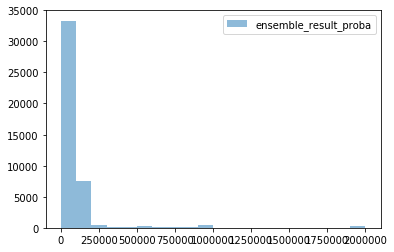

In [246]:
plt.hist(data_df['ConvertedSalary'],
        bins = 20,
        alpha = 0.5, 
        label = "ensemble_result_proba")

plt.legend(loc = 'upper right')
plt.show()

In [372]:
target_classification

1        1
4        0
5        0
6        1
8        2
        ..
89634    0
89754    2
89832    0
89839    1
89888    0
Name: ConvertedSalary, Length: 43201, dtype: int64

In [373]:
def helper(x):
    if x <= 60000:
        return "LOW"
    elif x > 200000:
        return "HIGH"
    else:
        return "MEDIUM"
target_classification = preprocessing.LabelEncoder().fit_transform(target.apply(helper))

In [385]:
target_classification

array([2, 1, 1, ..., 1, 2, 1])

In [409]:
(target_classification == 0).sum(),(target_classification == 1).sum(),(target_classification == 2).sum()

(2372, 21971, 18858)

## Model: Lightgbm

In [290]:
train_df.shape

(43201, 64)

In [382]:
x_train, x_test, y_train, y_test = train_test_split(train_df, target_classification, test_size = 0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)

In [410]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'application':"multiclass",
    'objective': 'multiclass',
    'num_class':3,
    'num_iterations': 1000,
    'learning_rate': 0.1,
    'max_depth': 20, 
#     'num_leaves': 60,
#     'feature_fraction':0.5,
#     'bagging_fraction':0.5,
#     'min_data_in_leaf': 80,
#     'max_bin': 10,
  
#     'lambda_l1': 80,
#     'lambda_l2': 60,
#     'scale_pos_weight': (target.count()-target.sum())/target.sum(),
#     'nthread': 6,
    
}

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

gbm = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=lgb_eval, early_stopping_rounds=50)

/Users/zhehaoguo/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.822648
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 0.788882
[3]	valid_0's multi_logloss: 0.760264
[4]	valid_0's multi_logloss: 0.736396
[5]	valid_0's multi_logloss: 0.716274
[6]	valid_0's multi_logloss: 0.698603
[7]	valid_0's multi_logloss: 0.682064
[8]	valid_0's multi_logloss: 0.667637
[9]	valid_0's multi_logloss: 0.655343
[10]	valid_0's multi_logloss: 0.645321
[11]	valid_0's multi_logloss: 0.636844
[12]	valid_0's multi_logloss: 0.628099
[13]	valid_0's multi_logloss: 0.621158
[14]	valid_0's multi_logloss: 0.613034
[15]	valid_0's multi_logloss: 0.60721
[16]	valid_0's multi_logloss: 0.600876
[17]	valid_0's multi_logloss: 0.595602
[18]	valid_0's multi_logloss: 0.591589
[19]	valid_0's multi_logloss: 0.586853
[20]	valid_0's multi_logloss: 0.583655
[21]	valid_0's multi_logloss: 0.579391
[22]	valid_0's multi_logloss: 0.576937
[23]	valid_0's multi_logloss: 0.573508
[24]	valid_0's multi_logloss: 0.571465
[25]	valid_0'

In [445]:
pred_train_prob = gbm.predict(x_train, num_iteration=gbm.best_iteration)

predictions_train = []
for x in pred_train_prob:
    predictions_train.append(np.argmax(x))
predictions_train = np.array(predictions_train)

In [ ]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [441]:
lg_train_auc = multiclass_roc_auc_score(y_train, predictions_train)
print("Train auc is",lg_train_auc)

Train auc is 0.7291304511125848


In [442]:
pred_test_prob = gbm.predict(x_test, num_iteration=gbm.best_iteration)

predictions_test = []
for x in pred_test_prob:
    predictions_test.append(np.argmax(x))
predictions_test = np.array(predictions_test)

lg_test_auc = multiclass_roc_auc_score(y_test, predictions_test)
print("Test auc is",lg_test_auc)

Test auc is 0.7213189512206662


### Feature importance: Shap

In [438]:
lgb_shap_explainer = shap.TreeExplainer(gbm)
lgb_shap_vals_train = lgb_shap_explainer.shap_values(x_train)
lgb_shap_vals_test = lgb_shap_explainer.shap_values(x_test)

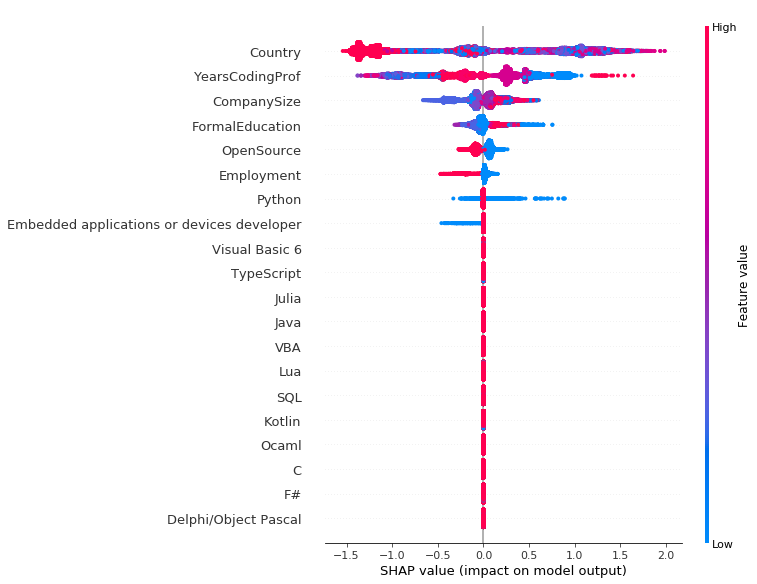

In [443]:
shap.summary_plot(lgb_shap_vals_train[1], x_train)

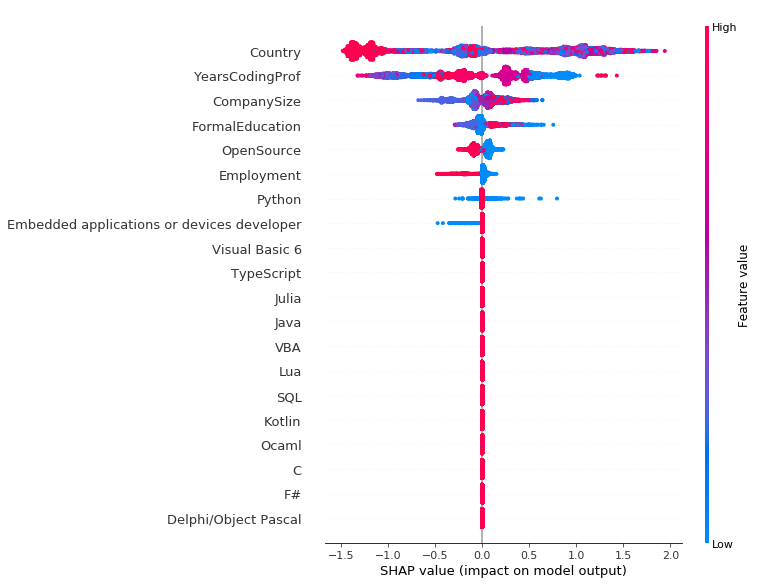

In [444]:
shap.summary_plot(lgb_shap_vals_test[1], x_test)